In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import gradio as gr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMAGES_DIR = r"/content/drive/MyDrive/HAM10000_images_combined_600x450"
MASKS_DIR  = r"/content/drive/MyDrive/HAM10000_segmentations_lesion_tschandl"


In [4]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
], is_check_shapes=False)

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])


In [5]:
class SkinLesionDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask  = np.array(Image.open(self.mask_paths[idx]).convert("L"))  # grayscale

        # تعديل مقاسات الماسك لتتساوى مع الصورة
        if image.shape[:2] != mask.shape[:2]:
            mask = np.array(Image.fromarray(mask).resize((image.shape[1], image.shape[0])))

        # Apply transforms if provided (albumentations returns tensors when using ToTensorV2)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask  = augmented['mask']
        else:
            # Convert numpy arrays to torch tensors in CHW format and normalize to 0-1
            image = torch.from_numpy(image.transpose(2,0,1)).float() / 255.0
            mask = torch.from_numpy(mask).unsqueeze(0).float() / 255.0

        # Ensure mask is a float tensor in 0-1 range and has shape (1,H,W)
        if isinstance(mask, torch.Tensor):
            if mask.dim() == 2:
                mask = mask.unsqueeze(0).float()
            else:
                mask = mask.float()
            if mask.max() > 1.1:
                mask = mask / 255.0

        return image, mask


In [6]:
import glob
import os

# جمع المسارات
image_paths = sorted(glob.glob(os.path.join(IMAGES_DIR, "*.jpg")))
mask_paths  = sorted(glob.glob(os.path.join(MASKS_DIR, "*.png")))

# عمل dictionary للماسكات بدون الجزء الزائد
mask_dict = {os.path.basename(p).replace("_segmentation","").split('.')[0]: p for p in mask_paths}

# ربط الصور بالماسكات الصحيحة
paired_images = []
paired_masks  = []

for img_path in image_paths:
    img_name = os.path.basename(img_path).split('.')[0]
    mask_path = mask_dict.get(img_name)
    if mask_path:
        paired_images.append(img_path)
        paired_masks.append(mask_path)

print("عدد الأزواج اللي تم العثور عليها:", len(paired_images))


عدد الأزواج اللي تم العثور عليها: 5210


In [7]:
split_idx = int(0.8 * len(paired_images))
train_images = paired_images[:split_idx]
train_masks  = paired_masks[:split_idx]
val_images   = paired_images[split_idx:]
val_masks    = paired_masks[split_idx:]

train_dataset = SkinLesionDataset(train_images, train_masks, transform=train_transform)
val_dataset   = SkinLesionDataset(val_images, val_masks, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("عدد عينات التدريب:", len(train_dataset))
print("عدد عينات التقييم:", len(val_dataset))

عدد عينات التدريب: 4168
عدد عينات التقييم: 1042


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


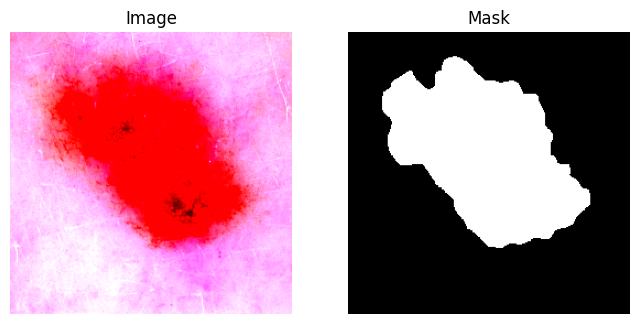

In [8]:
image, mask = train_dataset[5]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(image.permute(1,2,0))
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.show()


In [9]:
# Double Convolution Block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x_cat))


In [10]:
class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = SpatialAttention()
        self.dec4 = DoubleConv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = SpatialAttention()
        self.dec3 = DoubleConv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = SpatialAttention()
        self.dec2 = DoubleConv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = SpatialAttention()
        self.dec1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4 * self.att4(e4)], dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3 * self.att3(e3)], dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2 * self.att2(e2)], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1 * self.att1(e1)], dim=1)
        d1 = self.dec1(d1)

        out = self.final_conv(d1)
        return torch.sigmoid(out)


In [11]:
from torchvision import models

class CNNEncoder(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        return e1, e2, e3, e4, self.pool4(e4)


class TransUNetSkip(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, embed_dim=512):
        """Simplified TransUNet-like decoder.
        NOTE: original code attempted to pass CNN feature maps to a ViT from torchvision,
        which expects different inputs. For stability we use the CNN bottleneck directly
        (embed_dim defaults to 512 to match bottleneck channels). If you want a true
        ViT-based bottleneck, add a proper patch embedding and positional encoding.
        """
        super().__init__()
        self.cnn_encoder = CNNEncoder(in_channels)

        # Decoder layers (use embed_dim matching bottleneck channels)
        self.up4 = nn.ConvTranspose2d(embed_dim, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(512 + 512, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(128 + 128, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(64 + 64, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # CNN Encoder
        e1, e2, e3, e4, bottleneck = self.cnn_encoder(x)

        # Use bottleneck directly (no ViT) — shape should be [B,512,H/16,W/16]
        vit_feats = bottleneck

        # Decoder with skip connections
        d4 = self.up4(vit_feats)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final_conv(d1)
        return torch.sigmoid(out)


In [12]:
import torch.nn.functional as F

def dice_loss(pred, target, smooth=1e-5):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def combined_loss(pred, target):
    return dice_loss(pred, target) + F.binary_cross_entropy(pred, target)


In [13]:
def train_model(model, train_loader, val_loader, save_name, epochs=10, lr=1e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        # ===== تدريب =====
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # ===== تقييم =====
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = combined_loss(outputs, masks)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

        # حفظ أفضل موديل
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(),  save_name)
            print(f"Saved Best Model: {save_name} ✅")


In [14]:
attention_model = AttentionUNet().to(device)
train_model(attention_model, train_loader, val_loader, epochs=15, lr=1e-4, save_name="best_attention_unet.pth")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/15] - Train Loss: 0.7092 - Val Loss: 0.5541
Saved Best Model: best_attention_unet.pth ✅
Epoch [2/15] - Train Loss: 0.4912 - Val Loss: 0.4315
Saved Best Model: best_attention_unet.pth ✅
Epoch [3/15] - Train Loss: 0.3983 - Val Loss: 0.3646
Saved Best Model: best_attention_unet.pth ✅
Epoch [4/15] - Train Loss: 0.3410 - Val Loss: 0.3209
Saved Best Model: best_attention_unet.pth ✅
Epoch [5/15] - Train Loss: 0.3024 - Val Loss: 0.2961
Saved Best Model: best_attention_unet.pth ✅
Epoch [6/15] - Train Loss: 0.2877 - Val Loss: 0.2708
Saved Best Model: best_attention_unet.pth ✅
Epoch [7/15] - Train Loss: 0.2759 - Val Loss: 0.2829
Epoch [8/15] - Train Loss: 0.2640 - Val Loss: 0.2573
Saved Best Model: best_attention_unet.pth ✅
Epoch [9/15] - Train Loss: 0.2567 - Val Loss: 0.2519
Saved Best Model: best_attention_unet.pth ✅
Epoch [10/15] - Train Loss: 0.2448 - Val Loss: 0.2388
Saved Best Model: best_attention_unet.pth ✅
Epoch [11/15] - Train Loss: 0.2397 - Val Loss: 0.2591
Epoch [12/15] - Tra

In [15]:
trans_model = TransUNetSkip().to(device)
train_model(trans_model, train_loader, val_loader, epochs=15, lr=1e-4, save_name="best_transunet_skip.pth")

Epoch [1/15] - Train Loss: 0.6776 - Val Loss: 0.5255
Saved Best Model: best_transunet_skip.pth ✅
Epoch [2/15] - Train Loss: 0.4581 - Val Loss: 0.4000
Saved Best Model: best_transunet_skip.pth ✅
Epoch [3/15] - Train Loss: 0.3836 - Val Loss: 0.3492
Saved Best Model: best_transunet_skip.pth ✅
Epoch [4/15] - Train Loss: 0.3402 - Val Loss: 0.3340
Saved Best Model: best_transunet_skip.pth ✅
Epoch [5/15] - Train Loss: 0.3208 - Val Loss: 0.2875
Saved Best Model: best_transunet_skip.pth ✅
Epoch [6/15] - Train Loss: 0.3002 - Val Loss: 0.2844
Saved Best Model: best_transunet_skip.pth ✅
Epoch [7/15] - Train Loss: 0.2888 - Val Loss: 0.2826
Saved Best Model: best_transunet_skip.pth ✅
Epoch [8/15] - Train Loss: 0.2831 - Val Loss: 0.2916
Epoch [9/15] - Train Loss: 0.2722 - Val Loss: 0.2659
Saved Best Model: best_transunet_skip.pth ✅
Epoch [10/15] - Train Loss: 0.2654 - Val Loss: 0.2763
Epoch [11/15] - Train Loss: 0.2606 - Val Loss: 0.2659
Saved Best Model: best_transunet_skip.pth ✅
Epoch [12/15] - Tra

In [16]:
def visualize_predictions(model, dataset, num=3):
    model.eval()
    for i in range(num):
        img, mask = dataset[i]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device))[0,0].cpu().numpy()
            pred_mask = (pred > 0.5).astype(np.uint8)

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.title("Input Image")
        plt.imshow(img.permute(1,2,0).numpy())
        plt.subplot(1,3,2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask[0], cmap="gray")
        plt.subplot(1,3,3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap="gray")
        plt.show()


In [17]:
def load_model(model_name):
    if model_name == "Attention U-Net":
        model = AttentionUNet().to(device)
        model.load_state_dict(
            torch.load("best_attention_unet.pth", map_location=device)
        )

    elif model_name == "TransUNet Skip":
        model = TransUNetSkip().to(device)
        model.load_state_dict(
            torch.load("best_transunet_skip.pth", map_location=device)
        )

    else:
        raise ValueError("Model not supported")

    model.eval()
    return model


In [18]:
def predict(image, model_choice):
    model = load_model(model_choice)

    image_np = np.array(image)
    augmented = val_transform(image=image_np)
    input_tensor = augmented['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        pred_mask = model(input_tensor)[0, 0].cpu().numpy()

    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255
    return Image.fromarray(pred_mask)


In [19]:
iface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Image(type="pil", label="Input Image"),
        gr.Dropdown(
            choices=["Attention U-Net", "TransUNet Skip"],
            value="Attention U-Net",
            label="Choose Model"
        )
    ],
    outputs=gr.Image(type="pil", label="Predicted Mask"),
    title="Skin Lesion Segmentation",
    description="Choose a model and upload a dermoscopic image to see the predicted lesion mask"
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://155ec7205c899eab4d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
